---
Selecting CORINE Data for analysis
---


**Description:**  
From the large dataset, we can select a small batch of image for quick analysis

### Additional Comments
### Author: Viswambhar Yasa

### Date: 09-01-2024

**Contact Information:**  
Email: [yasa.viswambhar@gmail.com](mailto:yasa.viswambhar@gmail.com)

In [8]:
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [9]:
notebook_directory = Path().resolve().parent
sys.path.insert(0, str(notebook_directory.parent))
from sentinelmodels.preprocessing import LCSDataset
from sentinelmodels.pretrained_models import buildmodel
from experiment.helper_functions import save_dict,load_dict
from interpret.concept.conceptrelevance import ConceptRelevance

In [10]:
filename="./data/wilderness.pkl"
isExist = os.path.exists(filename)
if not isExist:
   os.makedirs(filename)

In [44]:

config={
            "root_dir":r'D:/master-thesis/Dataset/anthroprotect',
            "datasplitfilename": r"infos.csv",
            "n_classes":2,
            "n_labels":10,
            "device":"cpu",
            "inputimage_type":"rgb",   
            "modeltype":"vgg16",
            "modelweightspath":r"",
            "trainable":False,
            "epochs": 2,
            "batchsize": 8,
            "lr": 0.01,
            "optimizer":"resnet18",
            "gamma":1.5,
            #"modelweights":r"D:/finaldraft/ExplainingWilderness/wandb/run-20240103_142243-6r0q4htd/files/resnet18/best_model.pth",
            #"modelweights":r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/model_ckpoints/resnet18_multilabel/best_model.pth",
            #"modelweights":r"D:/finaldraft/ExplainingWilderness/wandb/run-20240104_092552-dvjp3w2j/files/alexnet/best_model.pth",
            #"modelweights":r"D:/finaldraft/ExplainingWilderness/wandb/run-20240104_183637-d6tzchdv/files/alexnet/best_model.pth",
            "modelweights":r"D:/finaldraft/ExplainingWilderness/wandb/run-20240105_153658-khua85pj/files/vgg16/best_model.pth",
            #"modelweights":r"",
            "datasettype":"train",
            "lrscheduler":"step_lr",
            "losstype":"binaryloss",
            "lossweights":list(np.ones(10)),
            "project_name":"wildernesslabels",
            "log_images":True,
            "log_image_index":5,
            "earlystop_patience":5,
            "earlystop_min_delta":0.05,
            "classnames":["A","W"]
}
csvfilepath=os.path.join(config["root_dir"],config["datasplitfilename"])
dataset = LCSDataset(csvfilepath, config["root_dir"],datasettype=config["datasettype"],device=config["device"])
data_loader = torch.utils.data.DataLoader(dataset, batch_size=config["batchsize"], shuffle=True)

In [42]:
run=False
if run:
    NUM_CLASSES = config["n_labels"]
    class_counts = torch.zeros(NUM_CLASSES, device='cuda:0')

    total_batches = len(data_loader)  # Total number of batches in the DataLoader
    index = 0
    for _, labels in tqdm(data_loader, desc="Processing batches", unit="batch"):
        index += 1
        labels = labels.to('cuda:0', non_blocking=True)
        class_counts += labels.sum(dim=0)
        progress = (index / total_batches) * 100
    class_counts[class_counts == 0] = 1
    print(class_counts)


In [13]:
print([15934., 12054.,    22.,  1857.,  1231., 16766., 10498.,  2479.,  5506.,
         6556.])

[15934.0, 12054.0, 22.0, 1857.0, 1231.0, 16766.0, 10498.0, 2479.0, 5506.0, 6556.0]


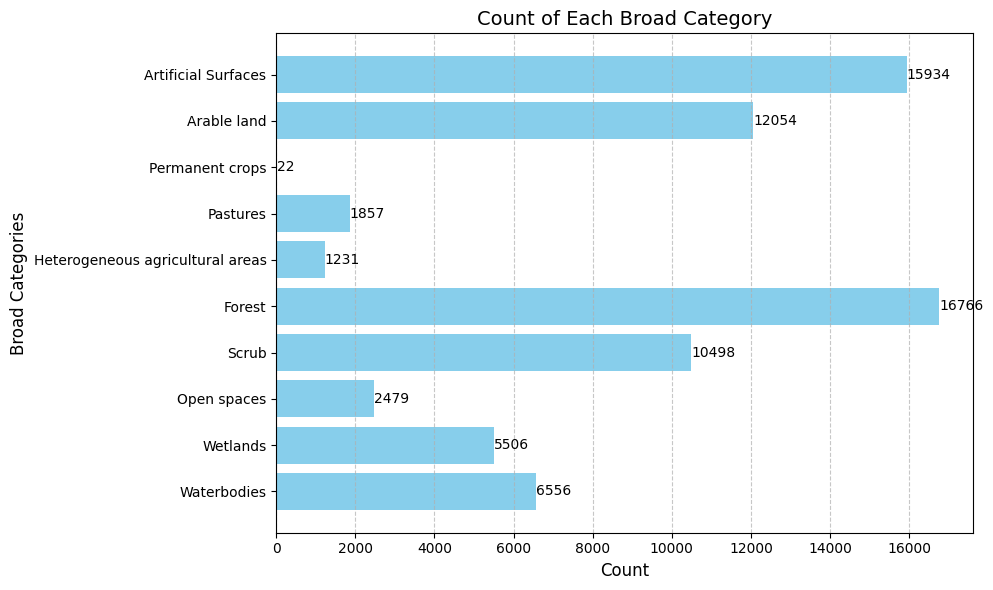

In [14]:
import matplotlib.pyplot as plt

broad_categories = [
    "Artificial Surfaces", "Arable land", "Permanent crops", "Pastures",
    "Heterogeneous agricultural areas", "Forest", "Scrub", "Open spaces",
    "Wetlands", "Waterbodies"
]
labels_count = [15934., 12054., 22., 1857., 1231., 16766., 10498., 2479., 5506., 6556.]

plt.figure(figsize=(10, 6))
bars = plt.barh(broad_categories, labels_count, color='skyblue')

plt.xlabel('Count', fontsize=12)
plt.ylabel('Broad Categories', fontsize=12)
plt.title('Count of Each Broad Category', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Displaying the count values at the end of each bar
for bar, count in zip(bars, labels_count):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, int(count),
             ha='left', va='center', color='black', fontsize=10)

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [15]:
import numpy as np

labels_count = np.array([15934., 12054., 22., 1857., 1231., 16766., 10498., 2479., 5506., 6556.])

total_samples = np.sum(labels_count)
class_weights = total_samples / (len(labels_count) * labels_count)

print("Class Weights:", class_weights)


Class Weights: [  0.45753107   0.60480338 331.37727273   3.92584814   5.92225833
   0.43482643   0.69444656   2.94082291   1.32406466   1.11200427]


In [16]:
config["lossweights"]=class_weights

In [17]:
model=buildmodel(config["modeltype"],config["n_labels"],None,parameterstrainable=config["trainable"],modelweightpath=config["modelweights"]).to(config["device"])

In [45]:
# Fetch a random batch
for images, labels in data_loader:
    random_batch_images, random_batch_labels = images, labels
    break

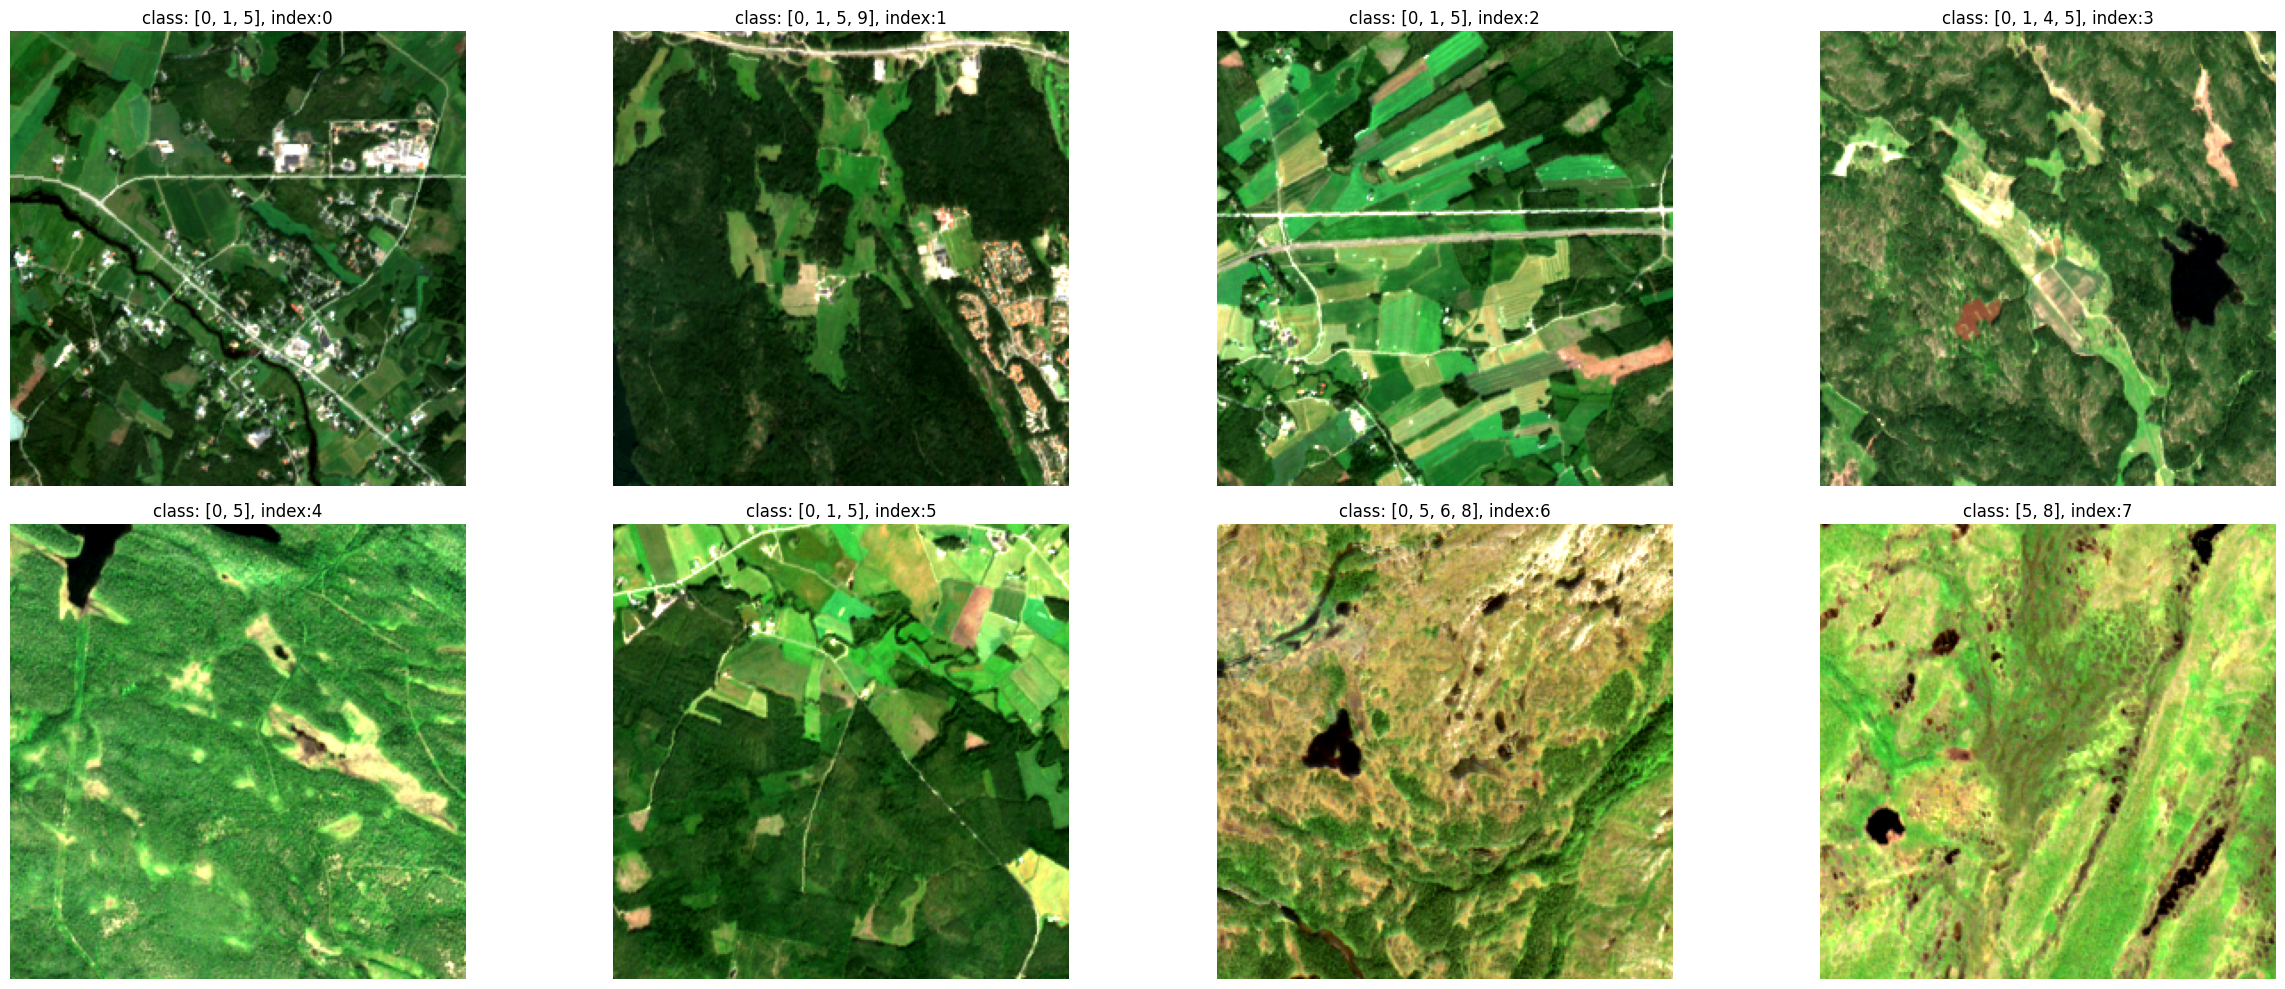

In [47]:
# Number of images in the batch
num_images = len(random_batch_images)

# Set up the matplotlib figure and axes
# The number of columns is half the number of images
# Adjust figsize to better fit your images
fig, axs = plt.subplots(2, int(num_images / 2), figsize=(25,10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate through the images and plot each one
for i in range(num_images):
    # Get the image and label
    image = random_batch_images[i].numpy().transpose(1, 2, 0)
    label = torch.nonzero(random_batch_labels[i] == 1).squeeze().tolist()

    # Plot the image in the corresponding subplot
    axs[i].imshow(image)
    axs[i].set_title(f"class: {label}, index:{i}")
    axs[i].axis('off')  # Turn off axis

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [32]:
prediction=model(random_batch_images)


In [33]:
Concepts=ConceptRelevance(model,device=config["device"])

In [48]:
index=4
condition=[{"y":[i]} for i in torch.nonzero(random_batch_labels[index] == 1).squeeze().tolist()]
inputimage=random_batch_images[index,:,:,:].unsqueeze(dim=0)

In [49]:
condition

[{'y': [0]}, {'y': [5]}]

In [50]:
relevance,_,p=Concepts.conditional_relevance(inputimage,condition=condition,compositename="epsilonplus",canonizerstype=config["modeltype"],output_type="sigmoid",record_layer=list(Concepts.layer_map.keys()))

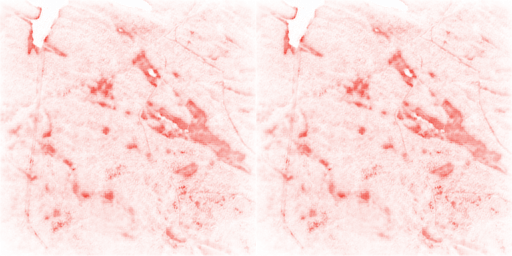

In [51]:
from crp.image import imgify
imgify(relevance.detach().cpu().numpy(), cmap="france", symmetric=True, level=1.,grid=(1,relevance.shape[0]))

In [45]:
selectedindex=[3,11,15,25]

In [46]:
data_dict = {'images': images[selectedindex,:,:,:], 'labels': labels[selectedindex]}

IndexError: index 11 is out of bounds for dimension 0 with size 8

In [ ]:
dictfilepath="./data/wilderness_data.pkl"
save_dict(data_dict,dictfilepath)

In [ ]:
wildernessdata=load_dict(dictfilepath)

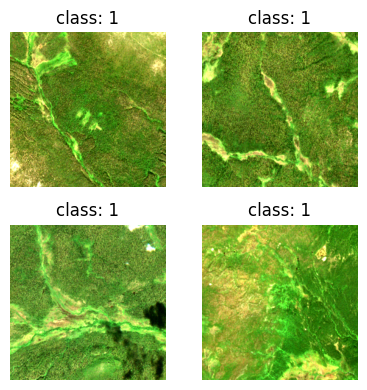

In [ ]:
images = data_dict['images']
labels=  data_dict['labels']
num_images = len(images)

# Calculate the grid size for plotting
cols = int(np.sqrt(num_images))
rows = num_images // cols
rows += num_images % cols

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

# If there's only one image, axs might not be an array
if num_images == 1:
    axs = [axs]

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate through the images and plot each one
for i in range(num_images):
    # Get the image
    image = images[i].numpy().transpose(1, 2, 0)  # Adjust this based on your image format
    label= labels[i]
    # Plot the image in the corresponding subplot
    axs[i].imshow(image)
    axs[i].set_title(f"class: {label}")
    axs[i].axis('off')  # Turn off axis

# Adjust layout and show the plot
plt.tight_layout()
plt.show()